## Tìm Hiểu và Áp Dụng Cơ Chế Attention
### Giới thiệu
Trong phần này mình hướng dẫn các bạn cách cài đặt cơ chế attention trong bài toán seq2seq đơn giản hóa. 

Cơ chế attention chỉ đơn giản là trung bình có trọng số của những “thứ” mà chúng ta nghĩ nó cần thiết cho bài toán, điều đặc biệt là trọng số này do mô hình tự học được. Cụ thể, trong bài toán dịch máy ở ví dụ dưới, khi sử dụng cơ chế attention để phát sinh từ little, mình sẽ cần tính một vector context C là trung bình có trọng số của vector biểu diễn các từ mặt, trời, bé, nhỏ tương ứng với vector h1,h2,h3,h4, rồi sử dụng thêm vector context c này tại lúc dự đoán từ little, và nhớ rằng, trọng số này là các số scalar, được mô hình tự học 

![attention](https://github.com/pbcquoc/attention_tutorial/raw/master/img/attn_seq2seq.png)


### Import thư viện
Mình sử dụng thêm cái lib của keras để hỗ trợ tiền xử lý cho nhanh, và tập trung chủ yếu vào phần cài đặt cơ chế attention


In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import torch.utils.data
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from random import randint

Using TensorFlow backend.


### Download tập huấn luyện
Để minh họa cơ chế attention, mình sử dụng tập dataset tự phát sinh, với đầu vào là các câu biểu diễn ngày tháng năm của con người đọc, và nhãn là ngày tháng năm tương ứng do máy tính hiểu.

Mình đã phát sinh tổng cộng 20k mẫu, trong đó 5k dùng để validation.

In [2]:
! curl --silent -L -o data.zip "https://drive.google.com/uc?export=download&id=1d6eUqRstk7NIpyASzbuIsDvBdHEwfU0g"
! unzip -q data.zip
! ls data

replace data/machine_vocab.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
data.csv  human_vocab.json  machine_vocab.json


### Tiền xử lý
Tập vocab mình xử dụng là các kí tự alphabet và số. Các bạn không cần phải filter, các kí tự đặt biệt trong tập dữ liệu

In [3]:
def load_data(path):
    df = pd.read_csv(path, header=None)
    X = df[0].values
    y = df[1].values
    x_tok = Tokenizer(char_level=True, filters='')
    x_tok.fit_on_texts(X)
    y_tok = Tokenizer(char_level=True, filters='')
    y_tok.fit_on_texts(y)
    
    X = x_tok.texts_to_sequences(X)
    y = y_tok.texts_to_sequences(y)
    
    X = pad_sequences(X)
    y = np.asarray(y)
    
    return X, y, x_tok.word_index, y_tok.word_index

X, y, x_wid, y_wid= load_data('data/data.csv')
x_id2w = dict(zip(x_wid.values(), x_wid.keys()))
y_id2w = dict(zip(y_wid.values(), y_wid.keys()))
X_train, X_test, y_train, y_test = train_test_split(X, y)
print('train size: {} - test size: {}'.format(len(X_train), len(X_test)))

train size: 18750 - test size: 6250


### Định nghĩa các tham số

In [4]:
# hidden size cho môt hình LSTM
hidden_size = 128
learning_rate = 0.001
decoder_learning_ratio = 0.1

# tập tự vựng của các câu đầu vào 
# +1 vì các bạn cần kí tự padding nhé!
input_size = len(x_wid) + 1

# +2 vì các bạn cần kí tự bắt đầu và kết thức
output_size = len(y_wid) + 2
# 2 kí tự này nằm ở cuối
sos_idx = len(y_wid) 
eos_idx = len(y_wid) + 1

max_length = y.shape[1]
print("input vocab: {} - output vocab: {} - length of target: {}".format(input_size, output_size, max_length))

input vocab: 35 - output vocab: 13 - length of target: 10


Chuyển sang dạng chuỗi kí tự đọc được từ chuỗi số

In [0]:
def decoder_sentence(idxs, vocab):
    text = ''.join([vocab[w] for w in idxs if (w > 0) and (w in vocab)])
    return text

## Định nghĩa mô hình
Ở phần này, các bạn cần định nghĩa 3 mô hình nhỏ
* Encoder: là một mô hình LSTM, dùng để học biểu diễn của câu
* Attention: dùng để học cách kết hợp để tạo ra context vector
* Decoder: là một mô hình LSTM, chúng ta sẽ kết hợp context vector vào mô hình này để dự đoán các từ tại mỗi thời điểm

![model](https://github.com/pbcquoc/pbcquoc.github.io/raw/master/images/attn_seq2seq_attn.png)

### Encoder
Mô hình này nhận đầu vào là các câu, các bạn có thể xem các hidden state h1,h2,h3,h4 như các biểu diễn của mỗi từ, và muốn tổng hợp context vector trên những thông tin này. 
### Attention
Mô hình này học các trọng số alpha trên các h1,h2,h3,h4 rồi sau đó tổng hợp context vector theo trung bình có trọng số alpha này
### Decoder
Ở thời điểm dự đoán, các bạn sử dụng thêm context vector để bổ sung thông tin cho mô hình. 

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        # embedding vector của từ
        self.embedding = nn.Embedding(input_size, hidden_size)
        # mô hình GRU biến thể RNN để học vector biểu diễn của câu
        self.gru = nn.GRU(hidden_size, hidden_size)
    
    def forward(self, input):
        # input: SxB        
        embedded = self.embedding(input)
        output, hidden = self.gru(embedded)
        return output, hidden # SxBxH, 1xBxH              

class Attn(nn.Module):
    def __init__(self, hidden_size):
        super(Attn ,self).__init__()
        
    def forward(self, hidden, encoder_outputs):
        ### Mô hình nhận trạng thái hidden hiện tại của mô hình decoder, 
        ### và các hidden states của mô hình encoder
        # encoder_outputs: TxBxH
        # hidden: SxBxH
        
        # tranpose về đúng shape để nhận ma trận
        encoder_outputs = torch.transpose(encoder_outputs, 0, 1) #BxTxH
        hidden = torch.transpose(torch.transpose(hidden, 0, 1), 1, 2) # BxHxS
        # tính e, chính là tương tác giữ hidden và các trạng thái ẩn của mô hình encoder 
        energies = torch.bmm(encoder_outputs, hidden) # BxTxS
        energies = torch.transpose(energies, 1, 2) # BxSxT
        # tính alpha, chính là trọng số của trung bình có trọng số cần tính bằng hàm softmax
        attn_weights = F.softmax(energies, dim=-1) #BxSxT
        
        # tính context vector bằng trung binh có trọng số
        output = torch.bmm(attn_weights, encoder_outputs) # BxSxH
        
        # trả về chiều cần thiết
        output = torch.transpose(output, 0, 1) # SxBxH
        attn_weights = torch.transpose(attn_weights, 0, 1) #SxBxT
        
        # return context vector và các trọng số alpha cho mục đích biểu diễn cơ chế attention
        return output, attn_weights
    
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, dropout):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # vector biểu diễn cho các từ của output
        self.embedding = nn.Embedding(output_size, hidden_size)
        # định nghĩa mô hình attention ở trên
        self.attn = Attn(hidden_size)
        self.dropout = nn.Dropout(dropout)
        # mô hình decoder là GRU
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        
        # dự đoán các từ tại mội thời điểm, chúng ta nối 2 vector hidden và context lại với nhau 
        self.concat = nn.Linear(self.hidden_size*2, hidden_size)        
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        # input: SxB
        # encoder_outputs: BxSxH
        # hidden: 1xBxH
        embedded = self.embedding(input) # 1xBxH
        embedded = self.dropout(embedded)
        
        # biểu diễn của câu
        rnn_output, hidden = self.gru(embedded, hidden)  #SxBxH, 1xBxH
        # tính context vector dựa trên các hidden states
        context, attn_weights = self.attn(rnn_output, encoder_outputs) # SxBxH
        
        # nối hidden state của mô hình decoder hiện tại và context vector để dự đoán 
        concat_input = torch.cat((rnn_output, context), -1)
        concat_output = torch.tanh(self.concat(concat_input)) #SxBxH
        
        # dự đoán kết quả tại mỗi thời điểm
        output = self.out(concat_output) # SxBxoutput_size
        return output, hidden, attn_weights



### Kiểm tra
Chúng ta khởi tạo mô hình để kiểm tra xem mô hình có chạy được không, ít nhất là không bị lỗi về tính toán

In [0]:
encoder = Encoder(input_size, hidden_size)
decoder = Decoder(output_size, hidden_size, 0.1)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()


input_encoder = torch.randint(1, input_size, (34, 6), dtype=torch.long)
encoder_outputs, hidden = encoder(input_encoder)
input_decoder = torch.randint(1, output_size, (10, 6), dtype=torch.long)
output, hidden, attn_weights = decoder(input_decoder, hidden, encoder_outputs)

## Train/test
Phần này chúng ta định nghĩa một số hàm để huấn luyện, dự đoán mô hình 

In [0]:
def forward_and_compute_loss(inputs, targets, encoder, decoder, criterion):
    batch_size = inputs.size()[1]
    
    # định nghĩa 2 kí tự bắt đầu và kết thúc
    sos = Variable(torch.ones((1, batch_size), dtype=torch.long)*sos_idx)
    eos = Variable(torch.ones((1, batch_size), dtype=torch.long)*eos_idx)
    
    # input của mô hình decoder phải thêm kí tự bắt đầu
    decoder_inputs = torch.cat((sos, targets), dim=0)
    # output cần dự đoán của mô hình decoder phải thêm kí tự kết thúc
    decoder_targets = torch.cat((targets, eos), dim=0)
    
    # forward tính hidden states của câu
    encoder_outputs, encoder_hidden = encoder(inputs)
    # tính output của mô hình decoder
    output, hidden, attn_weights = decoder(decoder_inputs, encoder_hidden, encoder_outputs)
    
    output = torch.transpose(torch.transpose(output, 0, 1), 1, 2) # BxCxS
    decoder_targets = torch.transpose(decoder_targets, 0, 1)
    # tính loss 
    loss = criterion(output, decoder_targets)
    
    return loss, output

def train(inputs, targets,  encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    # khai báo train để mô hình biết là đang train hay test
    encoder.train()
    decoder.train()
    
    # zero gradient, phải làm mỗi khi cập nhất gradient
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # tính loss dựa vào hàm đã định nghĩa ở trên
    train_loss, output = forward_and_compute_loss(inputs, targets,encoder, decoder,criterion)    
    
    train_loss.backward()
    # cập nhật một step
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    # return loss để print :D
    return train_loss.item()

def evaluate(inputs, targets, encoder, decoder, criterion):
    # báo cho mô hình biết đang test/eval
    encoder.eval()
    decoder.eval()
    # tính loss
    eval_loss, output = forward_and_compute_loss(inputs, targets, encoder, decoder,criterion)
    output = torch.transpose(output, 1, 2)
    # dự đoán của mỗi thời điểm các vị trí có prob lớn nhất
    pred_idx = torch.argmax(output, dim=-1).squeeze(-1)
    pred_idx = pred_idx.data.cpu().numpy()
    
    # return loss và kết quả dự đoán
    return eval_loss.item(), pred_idx

def predict(inputs, encoder, decoder, target_length=max_length):
    ### Lúc dự đoán chúng ta cần tính kết quả ngay lập tức tại mỗi thời điểm, 
    ### rồi sau đó dừng từ được dự đoán để tính từ tiếp theo        
    batch_size = inputs.size()[1]
    
    # input đầu tiên của mô hình decoder là kí tự bắt đầu, chúng ta dự đoán kí tự tiếp theo, sau đó lại dùng kí tự này để dự đoán từ kế tiếp
    decoder_inputs = Variable(torch.ones((1, batch_size), dtype=torch.long)*sos_idx)
    
    # tính hidden state của mô hình encoder, cũng là vector biểu diễn của các từ, chúng ta cần tính context vector dựa trên những hidden states này
    encoder_outputs, encoder_hidden = encoder(inputs)
    hidden = encoder_hidden
    
    preds = []
    attn_weights = []
    # chúng ta tính từng từ tại mỗi thời điểm
    for i in range(target_length):
        # dự đoán từ đầu tiên
        output, hidden, attn_weight = decoder(decoder_inputs, hidden, encoder_outputs)
        output = output.squeeze(dim=0)
        pred_idx = torch.argmax(output, dim=-1)
        
        # thay đổi input tiếp theo bằng từ vừa được dự đoán
        decoder_inputs = Variable(torch.ones((1, batch_size), dtype=torch.long)*pred_idx)
        preds.append(decoder_inputs)
        attn_weights.append(attn_weight.detach())
    
    preds = torch.cat(preds, dim=0)
    preds = torch.transpose(preds, 0, 1)
    attn_weights = torch.cat(attn_weights, dim=0)
    attn_weights = torch.transpose(attn_weights, 0, 1)
    return preds, attn_weights

### Train và eval
Trong phần này, chúng ta train mô hình, cũng như theo dõi độ lỗi, kết quả dự đoán tại mỗi epoch. 

In [9]:
epochs = 10
batch_size = 64

encoder = Encoder(input_size, hidden_size)
decoder = Decoder(output_size, hidden_size, 0.1)

# Initialize optimizers and criterion
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
criterion = nn.CrossEntropyLoss()

X_val = torch.tensor(X_test, dtype=torch.long)
y_val = torch.tensor(y_test, dtype=torch.long)
X_val = torch.transpose(X_val, 0, 1)
y_val = torch.transpose(y_val, 0, 1)

for epoch in range(epochs):
    for idx in range(len(X_train)//batch_size):
        # input đầu vào của chúng ta là timestep first nhé. 
        X_train_batch = torch.tensor(X_train[batch_size*idx:batch_size*(idx+1)], dtype=torch.long)
        y_train_batch = torch.tensor(y_train[batch_size*idx:batch_size*(idx+1)], dtype=torch.long)
        
        X_train_batch = torch.transpose(X_train_batch, 0, 1)
        y_train_batch = torch.transpose(y_train_batch, 0, 1)
        train_loss= train(X_train_batch, y_train_batch, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
    eval_loss, preds = evaluate(X_val, y_val, encoder, decoder, criterion)
    
    print('Epoch {} - train loss: {:.3f} - eval loss: {:.3f}'.format(epoch, train_loss, eval_loss))
    print_idx = np.random.randint(0, len(preds), 3)
    for i in print_idx:
        x_val = decoder_sentence(X_val[:,i].numpy(), x_id2w)
        y_pred = decoder_sentence(preds[i], y_id2w)
        print(" {:<35s}\t{:>10}".format(x_val, y_pred))

Epoch 0 - train loss: 0.533 - eval loss: 0.505
 7 11 17                            	7017-01-17
 tháng 3 14 1971                    	1971-03-12
 26 thg 3, 2013                     	2013-03-16
Epoch 1 - train loss: 0.197 - eval loss: 0.170
 ngày 03 tháng 04 năm 2008          	2008-04-03
 27 thg 11 1985                     	1985-01-27
 30 tháng 7 1975                    	1975-07-30
Epoch 2 - train loss: 0.112 - eval loss: 0.097
 14, thg 7 2013                     	2013-07-14
 05/12/1990                         	1990-02-05
 27 thg 10, 1990                    	1990-00-27
Epoch 3 - train loss: 0.050 - eval loss: 0.044
 10 thg 7, 1975                     	1975-07-10
 5 12 89                            	1989-12-05
 thứ ba, ngày 31 tháng 5 năm 2016   	2016-05-31
Epoch 4 - train loss: 0.028 - eval loss: 0.025
 ngày 27 tháng 04 năm 2000          	2000-04-27
 27 thg 1, 1974                     	1974-11-27
 27 11 00                           	2000-11-27
Epoch 5 - train loss: 0.027 - eval loss: 0.02

## Predict
Chúng ta dự đoán một vài mẫu và phân tích một số kết quả của cơ chế attention

In [0]:
preds, attn_weights = predict(X_val ,encoder, decoder, target_length=10)

In [0]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(input_sentence)))
    ax.set_xticklabels(list(input_sentence), rotation=90)
    ax.set_yticks(np.arange(len(output_words)))
    ax.set_yticklabels(list(output_words))
    ax.grid()
    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')
    plt.show()

Chọn ngẫu nhiên một câu trong tập validation để hiển thị. Khi hiển thị cơ chế attention, chúng ta có một cái nhìn về quá trình dự đoán của mô hình rõ ràng hơn, giúp đánh giá có thể interpretable hơn. 

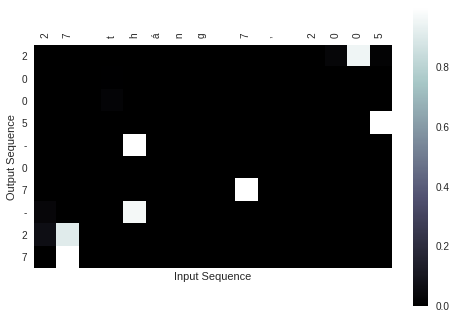

In [12]:
show_idx = randint(0, len(preds))
text_x = decoder_sentence(X_val[:,show_idx].numpy(), x_id2w)
text_y = decoder_sentence(preds[show_idx].numpy(), y_id2w)
attn_weight = attn_weights[show_idx, :, -len(text_x):]
show_attention(text_x, text_y, attn_weight)